# This Notebook Presents Results and Visualizations for SAE based on NCF architecture

In [ ]:
from typing import Callable, Any

import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import os
import numpy as np
import scipy
from scipy.sparse import csr_matrix
from pathlib import Path
from torch.utils.data import DataLoader
export_dir = os.getcwd()
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import plot
import random
import math
import heapq
from scipy.special import expit  # Sigmoid function
import itertools
from IPython.display import Latex, display
import pickle
import warnings

# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
torch.set_printoptions(sci_mode=False)

test_flag = 1

In [ ]:
pip install ipynb

In [ ]:
from ipynb.fs.defs.utils import *
from ipynb.fs.defs.data_processing import *
from ipynb.fs.defs.models import *
from ipynb.fs.defs.training import *

For SAE:

# Load MF Model:

In [ ]:
model_name_mf = 'MF_recommender'
with open(Path(export_dir,f'models/{model_name_mf}.pkl') , 'rb') as file:
    mf_recommender = pickle.load(file)
pos_idx_ex_use = mf_recommender.pos_idx_ex_use
neg_idx_ex_use = mf_recommender.neg_idx_ex_use
neg_ex = mf_recommender.neg_ex
neg_ex_hidden = mf_recommender.neg_ex_hidden
pos_ex_num = mf_recommender.pos_ex_num
pos_idx_ex_hidden = {(row): [item for item in pos_ex[row]
                if item not in mf_recommender.pos_idx_ex_use[row]] for
                     row in mf_recommender.R.index}
neg_ex_use = {(row): list(filter(lambda x: x not in neg_ex_hidden[row],
                                neg_ex[row])) for row in ratings_matrix.index}

# Load NCF Model:

In [ ]:
model_name_NCF = 'NCF_recommender'
model = torch.load(Path(export_dir,f'model/NCF_recommender.pth'), weights_only=False)

model.eval()

pos_idx_ex_use = model.pos_idx_ex_use
pos_idx_ex_hidden = {(row): [item for item in pos_ex[row] if item not in pos_idx_ex_use[row]] for row in ratings_matrix.index}



# get predictions for any 2 user-item embeddings-

In [ ]:
user_embeddings = model.user_embedding.weight.detach().clone()  # Tensor of shape (num_users, embedding_dim)
item_embeddings = model.item_embedding.weight.detach().clone()   # Tensor of shape (num_items, embedding_dim)

tensor([[ 1.0390, -0.2620, -0.2590,  ...,  0.5968, -0.3067, -0.0074],
        [-0.0889, -0.0834,  0.3751,  ..., -0.6603,  0.0381, -0.3255],
        [ 0.1838, -0.6648, -0.0162,  ..., -0.4260, -0.3214,  0.2457],
        ...,
        [-0.0398, -0.4404,  0.1537,  ..., -0.2578,  0.0666, -0.6223],
        [ 0.3662,  0.4229, -0.2406,  ...,  0.6519,  0.2481, -0.5007],
        [-0.2618, -0.4309,  0.7692,  ...,  0.6216,  1.3173, -0.0828]])

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim_matrix = cosine_similarity(item_embeddings)
df_cosine_sim_matrix = pd.DataFrame(cosine_sim_matrix)
df_cosine_sim_matrix

In [ ]:
# pd.DataFrame(user_embeddings.detach().numpy()).to_csv(Path(export_dir, 'NCF_user_embeddings.csv'), index = False)
# pd.DataFrame(item_embeddings.detach().numpy()).to_csv(Path(export_dir, 'NCF_item_embeddings.csv'), index = False)

In [ ]:
# df_u = pd.read_csv(Path(export_dir,'NCF_user_embeddings.csv'))
# df_v = pd.read_csv(Path(export_dir,'NCF_item_embeddings.csv'))

In [ ]:
df_v= pd.DataFrame(item_embeddings.numpy())
df_u= pd.DataFrame(user_embeddings.numpy())

df_item_emb1 = df_v.copy()
df_item_emb1.index = ratings_matrix.columns

df_user_emb1 = df_u.copy()
df_user_emb1.index = ratings_matrix.index

# Recommender- Evaluation Metrics

In [ ]:
avg_NDCG, ndcg_sum_all = ndcg_calc(k, model_type = 'NCF', pos_idx_ex_hidden, model=model)
mrr = mr_calc(k, model_type = 'NCF', pos_idx_ex_hidden, model=model)
hit_rate = hit_rate_calc(k, model_type = 'NCF', pos_idx_ex_hidden, model=model)
mean_percentile_rank = mpr_calc(model_type = 'NCF', pos_idx_ex_hidden, model=model)

## Load SAE NCF Model

In [ ]:
test_flag=1
model_name_SAE_NCF = 'SAE_NCF_model'

# sae_model = SparseAutoencoderNCF(input_dim=20, hidden_dim=22, topk=7, tie_weights=True)
sae_model = torch.load(Path(export_dir,f'models/{model_name_SAE_NCF}.pth'), weights_only = False)
sae_model.eval()

test_subset_users = sae_model.test_subset_users_ind
test_subset_items = sae_model.test_subset_items_ind
train_subset_users = [i for i in ratings_matrix.index if i not in test_subset_users]


In [ ]:
dataset_items = torch.tensor(df_item_emb.values, dtype=torch.float32)
dataset_users = torch.tensor(df_user_emb.values, dtype=torch.float32)

interaction_embeddings = dataset_users #[:, 2:]

# SAE Evaluation:

In [ ]:
reconstructions_users, latents_users=sae_model(user_embeddings)
reconstructions_items, latents_items=sae_model(item_embeddings)


## Tensor
latents_users=latents_users.detach().clone()
latents_items=latents_items.detach().clone()

reconstructions_users=reconstructions_users.detach().clone()
reconstructions_items=reconstructions_items.detach().clone()


## DataFrame
# users:
latents_df_usr = pd.DataFrame(latents_users.numpy())
latents_df_usr.index = ratings_matrix.index

recons_df_usr = pd.DataFrame(reconstructions_users.numpy())
recons_df_usr.index = ratings_matrix.index

#items:
latents_item_df = pd.DataFrame(latents_items.numpy())
latents_item_df.index = ratings_matrix.columns

reconstruction_item_df = pd.DataFrame(reconstructions_items.numpy())
reconstruction_item_df.index = ratings_matrix.columns

In [ ]:
latents_numpy_array_all_usr = latents_users.detach().clone()
latents_df_all_usr = pd.DataFrame(latents_numpy_array_all_usr)
latents_df_all_usr.index = ratings_matrix.index #df_user_emb.index


latents_items_numpy_array = latents_items.detach().clone().numpy()
latents_items_df = pd.DataFrame(latents_items_numpy_array)
latents_items_df.index = ratings_matrix.columns

# sparsity test:

In [ ]:
# how many neurons are activated or inavtivated   for each neuron
print(np.array((latents_users.detach() == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_users.detach() != 0).sum(axis=1)).mean())

print(np.array((latents_items.detach() == 0).sum(axis=1)).mean()) # sums up over columns for each column- item
print(np.array((latents_items.detach() != 0).sum(axis=1)).mean())

13.80394104984269
8.19605895015731
13.910685375067459
8.089314624932541


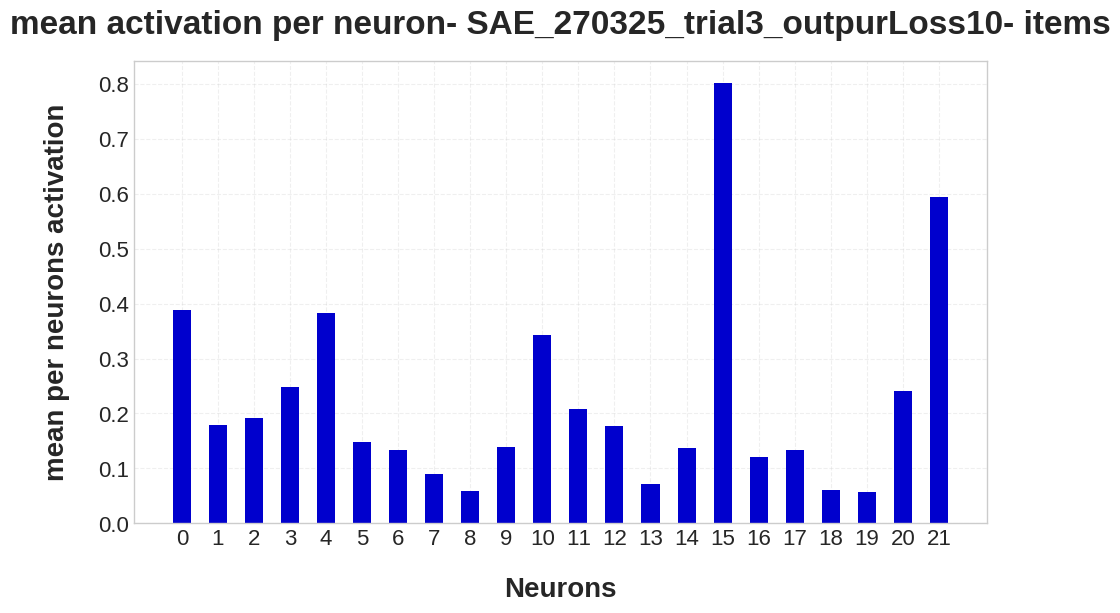

In [ ]:
# averaged activation on every neuron:

plt.figure(figsize=(11, 6))
r= plt.bar(latents_items_df.columns, latents_items_df.mean(), color='mediumblue', width = 0.5)
plt.title(f'mean activation per neuron- items', pad=20,weight='bold',fontsize=24)
plt.xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('mean per neurons activation', labelpad=20,weight='bold',fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(latents_items_df.columns,fontsize=16)
plt.yticks(fontsize=16)

plt.show()



In [ ]:
# averaged activation on every neuron:

plt.figure(figsize=(11, 6))
r= plt.bar(latents_df_all_usr.columns, latents_df_all_usr.mean(), color='mediumblue', width = 0.5)
plt.title(f'mean activation per neuron- users', pad=20,weight='bold',fontsize=24)
plt.xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('mean per neurons activation', labelpad=20,weight='bold',fontsize=20)
plt.grid(True, linestyle='--', alpha=0.3)

plt.xticks(latents_items_df.columns,fontsize=16)
plt.yticks(fontsize=16)

plt.show()



## RBO & Kendall Tau metrics

In [ ]:
# only test users
users_ind= ratings_matrix.index[sae_model.test_subset_users_ind]

lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])
# b_ = df_item_emb.copy()
# for i in range(b_.shape[0]):
#   b_.iloc[i,:]= reconstruction_item_df.iloc[i,:]

for user in lists_compare_table.index:

  # a_=df_user_emb.loc[user,:].copy()
  # for i in range(a_.shape[0]):
  #   a_.iloc[i]= recons_df_usr.loc[user,i]

  _,a,rec_orig = get_top_k_recommendations(model, user, list(range(3706)), 30)
  top_rec_user_id_orig = [int(t[0]) for t in rec_orig]
  # top_rec_user_id_orig = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, df_user_emb.iloc[user,:], df_item_emb.iloc[2500:3000,:])
  _,b,rec_reconst = get_top_k_recommendations_flex(model, user, list(range(3706)), 30)
  # top_rec_user_id_rec = rec_gen(movie_num, user, df_b_u_emb, df_b_i_emb, a_, b_)
  top_rec_user_id_rec = [int(t[0]) for t in rec_reconst]



  lists_compare_table.loc[user,'RBO Score'] = rbo(a, b)
  lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(a, b)


print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')




,0
RBO Score,0.759165
Kendall Tau Score,0.608558


ms score:

In [ ]:
ms_score_all_neurons(df_cosine_sim_matrix, latents_items)

# Latent activation Visualizations

In [ ]:
curr_female_ind = np.where(df_usr['gender']==1)
curr_df_gender_f = latents_df_all_usr.iloc[curr_female_ind[0],:]
curr_male_ind = np.where(df_usr['gender']==0)
curr_df_gender_m = latents_df_all_usr.iloc[curr_male_ind[0],:]
comparison = pd.concat([curr_df_gender_f.mean(), curr_df_gender_m.mean()],axis=1)


# Calculate mean activation per neuron for documentary movies
mean_activation_f = curr_df_gender_f.mean()
normalized_mean_activation_f = mean_activation_f / latents_df_all_usr.mean()
mean_activation_m = curr_df_gender_m.mean()
normalized_mean_activation_m = mean_activation_m / latents_df_all_usr.iloc[train_subset_users,:].mean()

diff=(normalized_mean_activation_f-normalized_mean_activation_m)

# diff[20] = 1.1
plt.style.use('seaborn-v0_8-whitegrid')

plt.figure(figsize=(16, 8))
plt.bar(latents_df_all_usr.columns, diff, color='tan', width=0.7)
# plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
plt.title(f'Mean Activation Difference: Women vs. Men', pad=20,weight='bold',fontsize=24)
# plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Activation Level Difference', labelpad=20,weight='bold',fontsize=20)
plt.xticks(latents_df_all_usr.columns,rotation=90,fontsize=16)
plt.yticks(fontsize=16)

plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
score_low = {}
score_high = {}

numerator_age = []
ages= [1, 18, 25,35,45, 50, 56]
ages_list = ['1','18','25','35','45','50','56']
for age in ages:
  numerator_age_ids = [i for i in np.where(df_usr.iloc[:,2]== age)[0]]
  numerator_age.append(len(numerator_age_ids))


ind = 0
for age in ages:

  curr_age_ind = np.where(df_usr['age']==int(age))
  curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
  if ind ==1:
      prev_df_age = curr_df_age.copy()

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
      comparison_age = pd.concat([prev_df_age.mean(), curr_df_age.mean()],axis=1)
  elif ind > 1:

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
      comparison_age = pd.concat([comparison_age ,curr_df_age.mean()],axis=1)
  else:

      curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]




  mean_activation = curr_df_age.mean()

  normalized_mean_activation = mean_activation / latents_df_all_usr.mean()
  if int(age) == 1:
    normalized_mean_activation_0 = normalized_mean_activation

  ind+=1


comparison_age.columns = ages_list

In [ ]:
# curr_age_ind = np.where(df_usr['age']!='1')
# curr_df_age = latents_df_all_usr.iloc[curr_age_ind[0],:]
# mean_activation = curr_df_age.mean()
# normalized_mean_activation_adult = mean_activation / latents_df_all_usr.mean()



# plt.figure(figsize=(10, 7))
# plt.bar(latents_df_all_usr.columns, normalized_mean_activation_0, color='tan', width=0.7)
# # plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
# plt.title(f'Mean Activation : young age- under 18', pad=20,weight='bold',fontsize=24)
# # plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
# plt.ylabel('Neuron Activation Level', labelpad=20,weight='bold',fontsize=20)
# plt.xticks(latents_df_all_usr.columns,fontsize=16)
# plt.yticks(fontsize=16)

# plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
# diff = normalized_mean_activation_0-normalized_mean_activation_adult

# plt.figure(figsize=(16, 8))
# plt.bar(latents_df_all_usr.columns, diff, color='tan', width=0.7)
# # plt.title(f'Diff mean activation between male and female', pad=20,weight='bold',fontsize=24)
# plt.title(f'Mean Activation Difference: young vs. adult', pad=20,weight='bold',fontsize=24)
# # plt.xlabel('Neuron', labelpad=20,weight='bold',fontsize=20)
# plt.ylabel('Activation Level Difference', labelpad=20,weight='bold',fontsize=20)
# plt.xticks(latents_df_all_usr.columns,fontsize=16)
# plt.yticks(fontsize=16)

# plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
keys_genres = list(genre_id.keys())


for ind, genre in enumerate(all_genres):

  curr_genre_ind = list(genre_id[(keys_genres[ind])])
  if ind ==1:
      prev_df_genre = curr_df_genre.copy()

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([prev_df_genre.mean(), curr_df_genre.mean()],axis=1)
  elif ind > 1:

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]
      comparison = pd.concat([comparison ,curr_df_genre.mean()],axis=1)
  else:

      curr_df_genre = latents_items_df.iloc[curr_genre_ind,:]



  fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))


  # Calculate mean activation per neuron for documentary movies
  mean_activation = curr_df_genre.mean()

  # Mean activation per neuron
  ax1.bar(latents_items_df.columns, mean_activation, color='tan', width=0.6)
  ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='mediumblue',width=0.1)


  ax1.set_title(f'Mean Activation per Neuron - {genre} Movies', pad=20,weight='bold',fontsize=24)
  ax1.set_xlabel('Neurons', labelpad=20,weight='bold',fontsize=20)
  ax1.set_ylabel('Mean Neuron Activation', labelpad=20,weight='bold',fontsize=20)
  ax1.grid(True, linestyle='--', alpha=0.5)
  ax1.set_xticks(range(len(latents_items_df.columns)))
  ax1.set_xticklabels(latents_items_df.columns,fontsize=18)
  # ax1.tick_params(axis='y', labelsize=14)
  ax1.tick_params(axis='both', which='major', labelsize=18)
  #ax1.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])

  leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  if ind == 1 or ind == 2 or ind== 3 or ind == 13:
      leg = ax1.legend([f'Mean neuron activation\nacrosss {genre} movies','Mean neuron activation\nacrosss all items'], loc='upper right', fontsize=16, fancybox=False,frameon=True)
  # Access the legend frame and set its edge color and linewidth
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)


comparison.columns = all_genres


In [ ]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'grey'
for index in comparison.index:

  # plt.show()
  plt.figure(figsize=(16, 8))
  r = plt.bar(all_genres, round(comparison.iloc[index,:],2), color='tan', width=0.6, edgecolor = 'darkgoldenrod', hatch = '//')
  plt.bar_label(r,fontsize=14)
  # plt.bar(all_genres, comparison.iloc[index, :], color='tan', width=0.6)
  plt.title(f'Neuron {index} - Mean Activation over Different Genres', pad=20, weight='bold', fontsize=24)
  plt.xlabel('Genres', labelpad=20, weight='bold', fontsize=20)
  plt.ylabel('Mean Activation Level', labelpad=20, weight='bold', fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw=2.5)

  leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper right', fontsize=16, fancybox=False)
  if index == 16 or index== 0 or index==1 or index==8 or index==9 or index== 18 or index== 21 or index== 14:
    leg = plt.legend([f'Mean neuron {index} activation\nacross all items'], loc='upper left', fontsize=16, fancybox=False)
  # Access the legend frame and set its edge color and linewidth
  frame = leg.get_frame()
  frame.set_edgecolor('grey')
  frame.set_linewidth(2)

  plt.grid(True, linestyle='--', alpha=0.5)
  plt.show()

# Further Latent Analysis and Manipulations:


## Activate one neuron in Latent representation

In [ ]:
movie = 1566
movie_ind = np.where(ratings_matrix.columns == movie)[0][0]

In [ ]:
x = item_embeddings.detach()[1016]
x = x.view(1, 20)


latent_pre_act = sae_model.encoder_linear(x) # (batch, hidden_dim)
curr_latents = sae_model.topk_activation(latent_pre_act)
curr_latents = torch.zeros_like(curr_latents)


neuron_one = 14
level = 4
curr_latents[:,neuron_one]=level
recons_unique = sae_model.decoder(curr_latents)
num_movies = 50

#---------------------------------

_, editeEncOut_recons_latents= sae_model(recons_unique.detach())
df_editeEncOut_recons_latents_post_enc = pd.DataFrame(editeEncOut_recons_latents.detach().numpy())

df_recons_edited = pd.DataFrame(recons_unique.detach().numpy())

score_low = {}
score_high = {}


fig, (ax1) = plt.subplots(1, 1, figsize=(10, 5))

# First bar chart: Mean activation per neuron
ax1.bar(latents_items_df.columns, df_editeEncOut_recons_latents_post_enc.T[0], color='coral')
ax1.bar(latents_items_df.columns+0.1, latents_items_df.mean(), color='blue',width=0.1)

ax1.set_title(f'Activation of recons of edited latents into enc, per Neuron',fontsize=14, weight='bold')
ax1.set_xlabel('Neurons',fontsize=17, weight='bold')
ax1.set_ylabel('Mean Neuron Activation',fontsize=17, weight='bold')
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_xticks(range(len(latents_items_df.columns)))
ax1.set_xticklabels(latents_items_df.columns, rotation=90,fontsize=15)
ax1.tick_params(axis='y', labelsize=15)


plt.tight_layout()
# Display the plots
plt.show()

score_low[genre] = list(np.where(normalized_activation >= 1.2)[0])
score_high[genre] = list(np.where(normalized_activation >= 2.5)[0])


#-----------------------------------------------------------------------------------------------------------------------------------


movie_num = 50
movie_num_test = 50

cosine_res = {}

test_mod_recons_embeddings = recons_unique
df_test_mod_recons_embeddings = pd.DataFrame(test_mod_recons_embeddings.detach().numpy())
magnitude_test_mod_recons_embeddings = np.linalg.norm(df_test_mod_recons_embeddings)

for i, movie_id in enumerate(ratings_matrix.columns):
  # if i in train_subset:
    curr_dot_product = np.dot(df_item_emb1.loc[movie_id].T,df_test_mod_recons_embeddings.T)
    curr_magnitude = np.linalg.norm(df_item_emb1.loc[movie_id])
    curr_cosine_similarity = curr_dot_product / (magnitude_test_mod_recons_embeddings * curr_magnitude)

    cosine_res[movie_id] = curr_cosine_similarity

max_key = max(cosine_res, key=cosine_res.get)
genres_test_mod_recons_embeddings = df_movie.columns[(np.where(df_movie.loc[max_key]==1)[0])].tolist()
topK_test_mod_recons_embeddings = heapq.nlargest(movie_num, cosine_res.items(), key=lambda x: x[1])


#-----------------------------------------------------------------------------------------------------------------------------------


table1_Wname = pd.DataFrame(0, index=range(num_movies), columns=['movie', 'name', 'genres','pop rank'])
for i in table1_Wname.index:
  table1_Wname.iloc[i,0] =  topK_test_mod_recons_embeddings[i][0]
  table1_Wname.iloc[i,1] =  (df_movie_names.loc[topK_test_mod_recons_embeddings[i][0]]).loc[1][0]
  table1_Wname.iloc[i,2] =  ','.join(df_movie.columns[(np.where(df_movie.loc[topK_test_mod_recons_embeddings[i][0]]==1)[0])].tolist())
  table1_Wname.iloc[i,3] =  np.where(num_users_per_movie_sort.index == topK_test_mod_recons_embeddings[i][0])[0][0]

print(f' mean popularity rank {table1_Wname.iloc[:,3].mean()} for top{num_movies}')


highly_activate_movies2neurons_table = pd.DataFrame(0, index=range(num_movies), columns=['Name','Year', 'Genres'])
for i in table1_Wname.index:
  highly_activate_movies2neurons_table.iloc[i,0] = (df_movie_names.loc[topK_test_mod_recons_embeddings[i][0]]).loc[1][0:-7]
  highly_activate_movies2neurons_table.iloc[i,1] = (df_movie_names.loc[topK_test_mod_recons_embeddings[i][0]]).loc[1][-5:-1]
  highly_activate_movies2neurons_table.iloc[i,2] =  ', '.join(df_movie.columns[(np.where(df_movie.loc[topK_test_mod_recons_embeddings[i][0]]==1)[0])].tolist())
highly_activate_movies2neurons_table



years_sum={}
years_sum['60']=[]
years_sum['70']=[]
years_sum['80']=[]
years_sum['90']=[]
years_sum['2000']=[]
# a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
for movie in table1_Wname.iloc[:,0]:
  if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['60'].append(movie)
  if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['70'].append(movie)
  if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['80'].append(movie)
  if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2001:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['90'].append(movie)
  if 2001<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['2000'].append(movie)

for key in (years_sum.keys()):
  years_sum[key]=len(years_sum[key])
print(f'division movies into years: {years_sum}')


print('\n')


#-----------------------------------------------------------------------------------------------------------------------------------



a=[topK_test_mod_recons_embeddings[i][0] for i in range(len(topK_test_mod_recons_embeddings))]
b = (df_movie.loc[a]).iloc[:,0:-1]


plt.figure(figsize=(10, 5))
numerator = (df_movie.loc[a].sum(axis=0)[0:-2]) if 'Cluster' in df_movie.columns else (df_movie.loc[a].sum(axis=0)[0:-1])

plt.bar(all_genres, numerator/movie_num, color='coral')
plt.title(f'Genres of {movie_num} most similar movies',fontsize=16, weight='bold')
plt.xlabel('genres',fontsize=15, weight='bold')
plt.ylabel('number of movies per genre',fontsize=17, weight='bold')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True, linestyle='--', alpha=0.5)




#--------------------------------------------------------------------------------------------------------------------------------------

plt.figure(figsize=(10, 5))
plt.bar(all_genres, comparison.iloc[neuron_one,:], color='coral')
plt.title(f'mean activation for neuron {neuron_one} over different genres',fontsize=18, weight='bold')
plt.xlabel('genres',fontsize=17, weight='bold')
plt.ylabel('mean activation',fontsize=17, weight='bold')
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.axhline(y=latents_items_df.mean().iloc[neuron_one], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)



highly_activate_movies2neurons_table.iloc[0:15,:]

# Testing K most dominant movies per neuron
##i.e.- topK movies that yielded the highest activation per neuron.

In [ ]:
'''a data frame contains the 500 most highly activated movies for each neuron
so each spot in the matrix is a movie number'''
size = 200

highly_activate_movies2neurons= pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,size))
for neuron in latents_items_df.columns:
  highly_activate_movies2neurons.loc[neuron,:] = latents_items_df.loc[:,neuron].nlargest(3706)[0:size].index

highly_activate_movies2neurons

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,3513,3717,624,3555,3238,3172,3779,3616,2584,3484,...,3406,1098,1558,2821,3597,1528,3818,3884,2480,3315
1,105,932,3528,1727,207,11,3257,1643,222,350,...,2062,1747,2497,182,218,34,25,3844,1784,1096
2,431,1095,1729,1245,1466,373,1213,1594,6,16,...,123,640,2329,2112,1916,1193,733,1244,1190,1249
3,1024,1025,313,2087,2089,2096,2048,2099,594,1032,...,2355,3488,2035,1083,3396,2874,3375,3615,808,2941
4,2798,3458,2296,833,1593,286,584,2592,3463,2597,...,2703,742,1390,818,2811,93,1432,1703,2515,177
5,3176,3408,3148,3952,3147,3155,2734,3160,2501,1873,...,2585,1678,1725,3163,3906,2943,3554,3299,529,2976
6,1097,1347,3471,2420,2789,1345,2003,1246,3708,1350,...,1346,2919,318,1393,230,2878,1061,1185,3676,1179
7,928,1717,916,1339,543,931,2550,1970,915,2186,...,2460,1875,1219,2465,2113,2491,2717,2080,903,1569
8,3219,2013,2598,3016,3203,2485,2840,2719,2734,2707,...,2387,2690,2917,2505,1459,79,2118,3408,3361,2423
9,3265,1218,741,2924,2275,3266,29,1306,1570,3300,...,2631,3539,2117,3007,162,442,2476,3681,3177,166


## Quantitative results

In [ ]:
for neuron in latents_items_df.columns:
  activated_per_neuron = df_movie.loc[highly_activate_movies2neurons.iloc[neuron,:],:]
  activated_per_neuron = activated_per_neuron.iloc[:,0:-1]
  norm_activated_per_neuron = activated_per_neuron.sum()/size
  plt.figure(figsize=(16, 8))
  r= plt.bar(activated_per_neuron.columns, norm_activated_per_neuron, color='tan', width=0.6, hatch= '//', edgecolor = 'darkgoldenrod')
  plt.bar_label(r,fontsize=14)
  plt.title(f'Neuron {neuron} - Genre Distribution of the {size} Most Dominant Movies', pad=20,weight='bold',fontsize=24)
  plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
  plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
  plt.xticks(rotation=90, fontsize=18)
  plt.yticks(fontsize=18)
  # plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
  plt.grid(True, linestyle='--', alpha=0.5)

In [ ]:
years_sum_df = pd.DataFrame(0,index=latents_items_df.columns,columns =years_sum.keys() )
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:size]
  years_sum={}

  years_sum['60']=[]
  years_sum['70']=[]
  years_sum['80']=[]
  years_sum['90']=[]
  years_sum['2000']=[]
  # a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
  for movie in a1.index:
    if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['60'].append(movie)
    if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['70'].append(movie)
    if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['80'].append(movie)
    if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2000:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['90'].append(movie)
    if 2000<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
    # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
      years_sum['2000'].append(movie)

  for key in (years_sum.keys()):
    years_sum[key]=round(len(years_sum[key])/size,4)
  years_sum_df.iloc[neuron,:] = years_sum.values()
  years_sum_df.columns = ['1960s and earlier', '1970s', '1980s', '1990s','2000s']


years_sum_df

,1960s and earlier,1970s,1980s,1990s,2000s
0,0.160,0.035,0.025,0.490,0.290
1,0.265,0.020,0.085,0.630,0.000
2,0.000,0.035,0.025,0.940,0.000
3,0.370,0.065,0.125,0.425,0.015
4,0.000,0.000,0.020,0.975,0.005
5,0.010,0.000,0.030,0.795,0.165
6,0.035,0.075,0.535,0.355,0.000
7,0.345,0.015,0.265,0.375,0.000
8,0.045,0.025,0.250,0.660,0.020
9,0.040,0.075,0.230,0.590,0.065


In [ ]:
activated_per_neuron = df_movie.loc[highly_activate_movies2neurons.iloc[5,:],:]
activated_per_neuron = activated_per_neuron.iloc[:,0:-1]
activated_per_neuron.sum()

,0
Children's,4
Drama,154
Action,18
Comedy,19
Adventure,3
Documentary,1
Animation,5
Crime,6
Fantasy,0
Film-Noir,0


In [ ]:
highly_activate_movies2neurons_name=highly_activate_movies2neurons.copy().iloc[:,0:10]
for i in range(highly_activate_movies2neurons_name.shape[0]):
  for j in range(highly_activate_movies2neurons_name.shape[1]):
    highly_activate_movies2neurons_name.iloc[i,j] = df_movie_names.loc[highly_activate_movies2neurons_name.iloc[i,j],1]

highly_activate_movies2neurons_name

,0,1,2,3,4,5,6,7,8,9
0,Rules of Engagement (2000),Gone in 60 Seconds (2000),Condition Red (1995),U-571 (2000),Eye of the Beholder (1999),Ulysses (Ulisse) (1954),Project Moon Base (1953),Loser (2000),Foolish (1999),"Skulls, The (2000)"
1,"Bridges of Madison County, The (1995)","Affair to Remember, An (1957)","Prince of Tides, The (1991)","Horse Whisperer, The (1998)","Walk in the Clouds, A (1995)","American President, The (1995)","Bodyguard, The (1992)","Mrs. Brown (Her Majesty, Mrs. Brown) (1997)",Circle of Friends (1995),"Client, The (1994)"
2,Carlito's Way (1993),Glengarry Glen Ross (1992),Jackie Brown (1997),Miller's Crossing (1990),Donnie Brasco (1997),Red Rock West (1992),GoodFellas (1990),In the Company of Men (1997),Heat (1995),Casino (1995)
3,"Three Caballeros, The (1945)","Sword in the Stone, The (1963)","Swan Princess, The (1994)",Peter Pan (1953),"Rescuers Down Under, The (1990)",Sleeping Beauty (1959),"Great Mouse Detective, The (1986)",Song of the South (1946),Snow White and the Seven Dwarfs (1937),Alice in Wonderland (1951)
4,Problem Child (1990),Blood and Sand (Sangre y Arena) (1989),"Night at the Roxbury, A (1998)",High School High (1996),Picture Perfect (1997),Nemesis 2: Nebula (1995),I Don't Want to Talk About It (De eso no se ha...,"Joyriders, The (1999)",Last Resort (1994),Lost & Found (1999)
5,"Talented Mr. Ripley, The (1999)",Erin Brockovich (2000),"Cider House Rules, The (1999)","Contender, The (2000)","Green Mile, The (1999)",Anna and the King (1999),"Mosquito Coast, The (1986)",Magnolia (1999),October Sky (1999),"Misérables, Les (1998)"
6,E.T. the Extra-Terrestrial (1982),"Nightmare on Elm Street, A (1984)",Close Encounters of the Third Kind (1977),"Karate Kid, The (1984)",Damien: Omen II (1978),Carrie (1976),Gremlins (1984),Dead Poets Society (1989),Firestarter (1984),"Omen, The (1976)"
7,Rebecca (1940),Scream 2 (1997),Roman Holiday (1953),Bram Stoker's Dracula (1992),So I Married an Axe Murderer (1993),Spellbound (1945),"Haunting, The (1963)","Nightmare on Elm Street 3: Dream Warriors, A (...",Sabrina (1954),Strangers on a Train (1951)
8,Pacific Heights (1990),"Poseidon Adventure, The (1972)",Pushing Tin (1999),Creepshow (1982),Dead Calm (1989),She's All That (1999),Stigmata (1999),"Haunting, The (1999)","Mosquito Coast, The (1986)",Arlington Road (1999)
9,Hard-Boiled (Lashou shentan) (1992),"Killer, The (Die xue shuang xiong) (1989)",Ghost in the Shell (Kokaku kidotai) (1995),Drunken Master (Zui quan) (1979),Six-String Samurai (1998),Man Bites Dog (C'est arrivé près de chez vous)...,"City of Lost Children, The (1995)",Until the End of the World (Bis ans Ende der W...,Tetsuo II: Body Hammer (1992),Pitch Black (2000)


## a list of the most dominant movies in a certain neuron

In [ ]:
# testing specific neuron's dominant movies

neuron_interest = 3
table_size = 30
neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]

highly_activate_movies2neurons_table = table_maker_Wchoice(table_size,neuron_data , selected_columns=['Name','Year', 'Genre'])
highly_activate_movies2neurons_table[0:10,:]

,movie,name,genres,pop rank
1,1025,"Sword in the Stone, The (1963)","[""Children's"", 'Animation']",1079
2,313,"Swan Princess, The (1994)","[""Children's"", 'Animation']",2444
3,2087,Peter Pan (1953),"[""Children's"", 'Animation', 'Fantasy', 'Musical']",503
4,2089,"Rescuers Down Under, The (1990)","[""Children's"", 'Animation']",1245
5,2096,Sleeping Beauty (1959),"[""Children's"", 'Animation', 'Musical']",603
6,2048,"Great Mouse Detective, The (1986)","[""Children's"", 'Animation']",1803
7,2099,Song of the South (1946),"[""Children's"", 'Adventure', 'Animation', 'Musi...",1322
8,594,Snow White and the Seven Dwarfs (1937),"[""Children's"", 'Animation', 'Musical']",344
9,1032,Alice in Wonderland (1951),"[""Children's"", 'Animation', 'Musical']",585
10,3759,Fun and Fancy Free (1947),"[""Children's"", 'Animation', 'Musical']",2729


In [ ]:
# testing specific neuron's dominant movies

neuron_interest = 13
table_size = 30
neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]

highly_activate_movies2neurons_table = table_maker_Wchoice(table_size,neuron_data , selected_columns=['Name','Year', 'Genre'])
highly_activate_movies2neurons_table[0:10,:]

,Name,Year,Genres
1,Fletch,1985,Comedy
2,Risky Business,1983,Comedy
3,Private Benjamin,1980,Comedy
4,Bachelor Party,1984,Comedy
5,Ruthless People,1986,Comedy
6,Weird Science,1985,Comedy
7,Vacation,1983,Comedy
8,Fast Times at Ridgemont High,1982,Comedy
9,Sixteen Candles,1984,Comedy
10,Airplane!,1980,Comedy


In [ ]:
# testing specific neuron's dominant movies

neuron_interest = 12
table_size = 30
neuron_data = highly_activate_movies2neurons.iloc[neuron_interest,:]

highly_activate_movies2neurons_table = table_maker_Wchoice(table_size, neuron_data , selected_columns=['Name','Year', 'Genre'])
highly_activate_movies2neurons_table



,Name,Year,Genres
0,Independence Day (ID4),1996,"Action, Sci-Fi, War"
1,Die Hard 2,1990,"Action, Thriller"
2,Clear and Present Danger,1994,"Action, Adventure, Thriller"
3,Die Hard: With a Vengeance,1995,"Action, Thriller"
4,Predator 2,1990,"Action, Sci-Fi, Thriller"
5,Stargate,1994,"Action, Adventure, Sci-Fi"
6,Deep Impact,1998,"Drama, Action, Sci-Fi, Thriller"
7,"Jackal, The",1997,"Action, Thriller"
8,Executive Decision,1996,"Action, Thriller"
9,Patriot Games,1992,"Action, Thriller"


# Other concepts:

## Popularity Neuron

In [ ]:
'''we take latent_items_df, sort each columns top value- i.e- we can tell what
are the 500 most dominant movies for each neuron- by the size of their activation.
then we initialize 'pop_rank_df' of size neurons_num X 500 items, we fill in
there the popularity rank of the 500 most dominant movies for each neuron
(calculated earlier), find the mean of the popularilty rank for the 500 most
dominant movies for each neuron..
which describes the 'poplarity level' each neuron might describe'''

pop_rank_df = pd.DataFrame(0,index=latents_items_df.columns,columns =range(0,500))
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:500]
  for id, movie in enumerate(a1.index):
    pop_rank_df.loc[neuron,id]= np.where(num_users_per_movie_sort.index == a1.index[id])[0][0]
pop_rank_df.mean(axis=1)



,0
0,1146.858
1,2826.112
2,1507.252
3,733.026
4,1540.008
5,864.924
6,2229.402
7,2096.174
8,2542.194
9,1377.610


## decadal distribution

In [ ]:
'''what isthe decadal distribution in the whole dataset'''

years_sum={}
years_sum['60']=[]
years_sum['70']=[]
years_sum['80']=[]
years_sum['90']=[]
years_sum['2000']=[]
# a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
for movie in df_movie.index:
  if 1900<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['60'].append(movie)
  if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['70'].append(movie)
  if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['80'].append(movie)
  if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2000:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['90'].append(movie)
  if 2000<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
  # years.append(int(df_movie_names.loc[movie].iloc[0][-5:-1]))
    years_sum['2000'].append(movie)

for key in (years_sum.keys()):
  years_sum[key]=len(years_sum[key])
years_sum

{'60': 570, '70': 240, '80': 592, '90': 2152, '2000': 152}

In [ ]:
''''decadal distribution for topK most ominant for each neuron'''

years_sum_df = pd.DataFrame(0,index=latents_items_df.columns,columns =years_sum.keys() )
for neuron in latents_items_df.columns:
  a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:200]
  years_sum={}

  years_sum['60']=[]
  years_sum['70']=[]
  years_sum['80']=[]
  years_sum['90']=[]
  years_sum['2000']=[]
  # a1=latents_items_df.loc[:,neuron].nlargest(3706)[0:100]
  for movie in a1.index:
    if int(df_movie_names.loc[movie].iloc[0][-5:-1])<1970:
      years_sum['60'].append(movie)
    if 1970<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1980:
      years_sum['70'].append(movie)
    if 1980<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<1990:
      years_sum['80'].append(movie)
    if 1990<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2000:
      years_sum['90'].append(movie)
    if 2000<=int(df_movie_names.loc[movie].iloc[0][-5:-1])<2010:
      years_sum['2000'].append(movie)

  for key in (years_sum.keys()):
    years_sum[key]=round(len(years_sum[key])/200,3)
  years_sum_df.iloc[neuron,:] = years_sum.values()
  years_sum_df.columns = ['1960s and earlier', '1970s', '1980s', '1990s','2000s']


years_sum_df

,1960s and earlier,1970s,1980s,1990s,2000s
0,0.160,0.035,0.025,0.490,0.290
1,0.265,0.020,0.085,0.630,0.000
2,0.000,0.035,0.025,0.940,0.000
3,0.370,0.065,0.125,0.425,0.015
4,0.000,0.000,0.020,0.975,0.005
5,0.010,0.000,0.030,0.795,0.165
6,0.035,0.075,0.535,0.355,0.000
7,0.345,0.015,0.265,0.375,0.000
8,0.045,0.025,0.250,0.660,0.020
9,0.040,0.075,0.230,0.590,0.065


In [ ]:
N=20

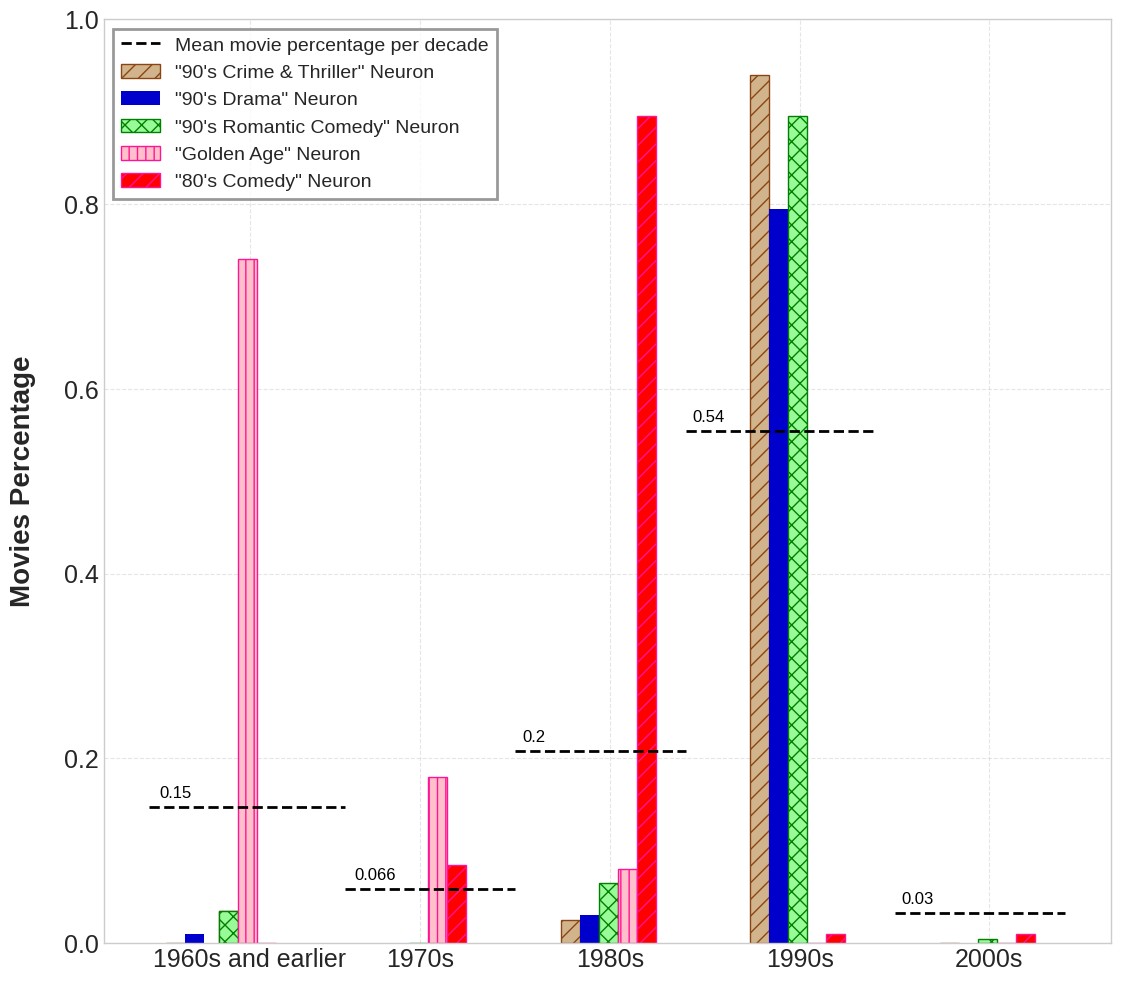

In [ ]:
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.edgecolor'] = 'grey'
hatches = ['//', 'xx', '||']

plt.figure(figsize=(13, 12))
r0=plt.bar([-0.19,0.09,1.89,2.89,3.89], years_sum_df.iloc[2,:], color='tan', width=0.1,edgecolor='saddlebrown',  hatch = hatches[0])
r2=plt.bar([-0.09,0.99,1.99,2.99,2.99], years_sum_df.iloc[5,:], color='mediumblue', width=0.1)
r3=plt.bar([0.09,1.09,2.09,3.09,4.09], years_sum_df.iloc[14,:], color='palegreen', width=0.1,edgecolor='green', hatch = hatches[1])
r4 = plt.bar([0.19, 1.19, 2.19,3.19, 4.19], years_sum_df.iloc[20,:], color='pink', width=0.1,edgecolor='deeppink', hatch = hatches[2])
r5 = plt.bar([0.29, 1.29, 2.29,3.29,4.29], years_sum_df.iloc[13,:], color='red', width=0.1,edgecolor='deeppink', hatch = hatches[0])


plt.title(f'Decadal Distribution of the 300 Most Dominant Movies', pad=20,weight='bold',fontsize=24)
plt.xlabel('Decade', labelpad=20,weight='bold',fontsize=20)
plt.ylabel('Movies Percentage', labelpad=20,weight='bold',fontsize=20)
plt.xticks([0.2,1.1,2.1,3.1, 4.1], labels = list(years_sum_df.columns),fontsize=18)
plt.yticks([0.0,0.2,0.4,0.6, 0.8,1.0],fontsize=18)
# plt.axhline(y=latents_items_df.mean().iloc[index], color='blue', linestyle='--', lw = 2.5)
plt.grid(True, linestyle='--', alpha=0.5)
leg = plt.legend(['Mean movie percentage per decade',f'"90\'s Crime & Thriller" Neuron', '"90\'s Drama" Neuron', '"90\'s Romantic Comedy" Neuron',f'"Golden Age" Neuron', '"80\'s Comedy" Neuron'],frameon=True, loc='best', fontsize=14, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)


# USE CASES

## generate new audience out of test set

In [ ]:
usersGroup = generate_users_test_group('Children\'s', N, sae_model)
usersGroup

## test some of the users in the group

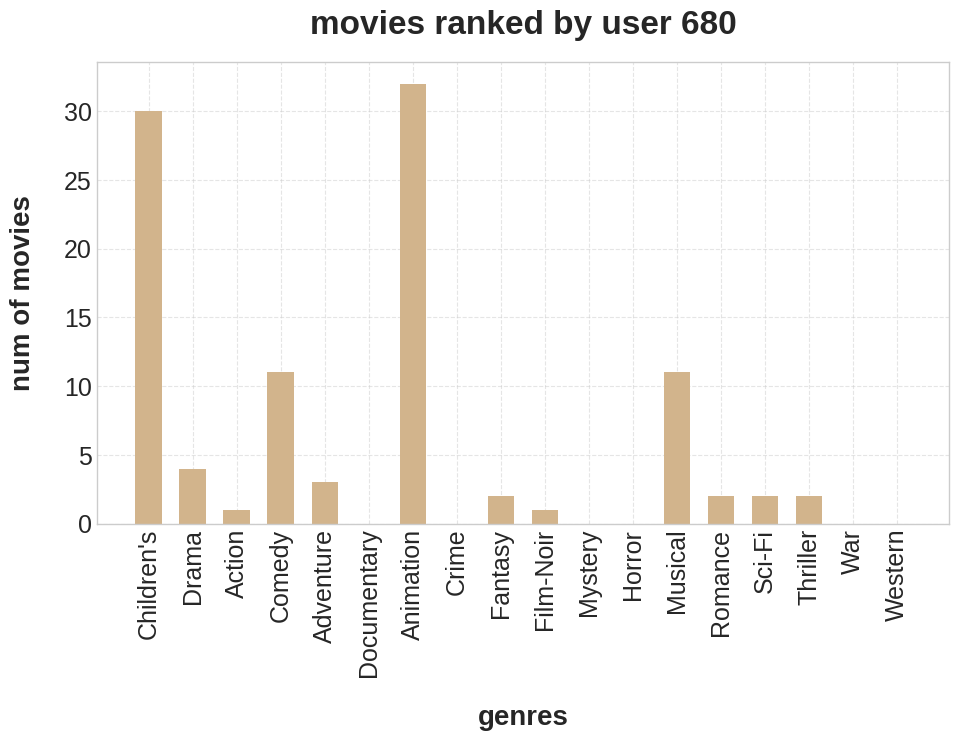

,movie,name,genres,pop rank
0,1,Toy Story (1995),"[""Children's"", 'Comedy', 'Animation', 'movie_id']",29
1,13,Balto (1995),"[""Children's"", 'Animation']",2016
2,48,Pocahontas (1995),"[""Children's"", 'Animation', 'Musical', 'Romance']",835
3,588,Aladdin (1992),"[""Children's"", 'Comedy', 'Animation', 'Musical']",96
4,594,Snow White and the Seven Dwarfs (1937),"[""Children's"", 'Animation', 'Musical']",344
5,595,Beauty and the Beast (1991),"[""Children's"", 'Animation', 'Musical']",182
6,661,James and the Giant Peach (1996),"[""Children's"", 'Animation', 'Musical']",584
7,673,Space Jam (1996),"[""Children's"", 'Comedy', 'Adventure', 'Animati...",540
8,709,Oliver & Company (1988),"[""Children's"", 'Animation']",1722
9,783,"Hunchback of Notre Dame, The (1996)","[""Children's"", 'Animation', 'Musical']",812


In [ ]:
np.uintser =680
'''ranked movies '''

ranked_movies_index = np.where(ratings_matrix.iloc[user]==1)[0]
ranked_movies_name = ratings_matrix.columns[np.where(ratings_matrix.iloc[user]==1)[0]]
genre_histogram = df_movie.iloc[ranked_movies_index,:-1].sum()


plt.figure(figsize=(11, 6))
plt.bar(all_genres, genre_histogram, color='tan', width=0.6)
plt.title(f'movies ranked by user {user}', pad=20,weight='bold',fontsize=24)
plt.ylabel('num of movies', labelpad=20,weight='bold',fontsize=20)
plt.xlabel('genres', labelpad=20,weight='bold',fontsize=20)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.show()

#------------------------------------------------------------------------------


table1_rec_Wname = pd.DataFrame(0, index=range(len(ranked_movies_name)), columns=['movie', 'name', 'genres','pop rank'])
for i in table1_rec_Wname.index:
  table1_rec_Wname.iloc[i,0] =  ranked_movies_name[i]
  table1_rec_Wname.iloc[i,1] =  df_movie_names.loc[ranked_movies_name[i]].iloc[0]
  table1_rec_Wname.iloc[i,2] =  str(df_movie.columns[(np.where(df_movie.loc[ranked_movies_name[i]]==1)[0])].tolist())
  table1_rec_Wname.iloc[i,3] =  np.where(num_users_per_movie_sort.index == ranked_movies_name[i])[0][0]


table1_rec_Wname

In [ ]:
movie_num = 30

top_rec_user_id = get_top_k_recommendations(model, user, list(range(3706)), movie_num)[1]

rec_genre_hist = df_movie.iloc[top_rec_user_id,:-1].sum()


plt.figure(figsize=(11, 6))
plt.bar(all_genres, rec_genre_hist, color='tan', width=0.6)
plt.title(f'Top{movie_num} Recommendations for User {user}', pad=20,weight='bold',fontsize=24)
plt.ylabel('Num of Movies', labelpad=20,weight='bold',fontsize=20)
plt.xlabel('Genres', labelpad=20,weight='bold',fontsize=20)
# ax1.axhline(y=latents_df.mean().iloc[index], color='blue', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=90,fontsize=18)
plt.yticks(fontsize=18)
plt.show()


table1_rec_Wname = table_maker(movie_num, top_rec_user_id, df_movie, df_movie_names, num_users_per_movie_sort)


table1_rec_Wname

# Modify Item Latent Representation

## Item Exposure to new audience

In [ ]:
numUsersTotopk = []
numUsersOuttopk_orig = []
movie_num = 3706
test_movie = 377
ind_movie = np.where(ratings_matrix.columns==test_movie)[0][0]
th = 20
neuron = 3


neuron_levels = [0,1,2,3,4]


'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(usersGroup.index)), columns=['user', 'orig rec rank']+[f'new rec rank_lev{lev}' for lev in neuron_levels[1:]])

for ind_lev, level in enumerate(neuron_levels):
  print(f'level: {level}')

  for ind,user_movie_test in enumerate(usersGroup.index):


    # modified movie:
    movie_act =  latents_item_df.copy().loc[test_movie,:]
    movie_act_new = movie_act.copy(deep=True)
    movie_act_new.iloc[neuron] = level

    recons_unique = sae_model.decoder(torch.tensor(movie_act_new))

    df_item_emb_copy= df_item_emb.copy(deep=True)
    df_item_emb_copy.iloc[ind_movie,:]=pd.DataFrame(recons_unique.detach().numpy()).iloc[:,0]


    if level == 0 :
      top_rec_user_id_orig = get_top_k_recommendations_flex_item(model, user_movie_test, list(range(3706)), movie_num, recons_unique.detach().clone(), ind_movie)[1]
      table1_rec_Wname_orig = table_maker(movie_num, top_rec_user_id_orig, df_movie, df_movie_names, num_users_per_movie_sort)

    top_rec_user_id_new = get_top_k_recommendations_flex_item(model, user_movie_test, list(range(3706)), movie_num, recons_unique.detach().clone(), ind_movie)[1]
    table1_rec_Wname_new = table_maker(movie_num, top_rec_user_id_new, df_movie, df_movie_names, num_users_per_movie_sort)


    # #--------------------------------------------------------------------------------------

    table.iloc[ind,0] = user_movie_test
    if level == 0 :
      table.iloc[ind,1] = np.where(table1_rec_Wname_orig.iloc[:,0]==test_movie)[0][0]
    else:
      table.iloc[ind,1+ind_lev] = np.where(table1_rec_Wname_new.iloc[:,0]==test_movie)[0][0]

  to_top50 = []
  remain_top50 = []
  from_top50 = []
  count_in_top50_orig = 0
  count_out_top50_orig = 0
  for i in table.index:
    if table.iloc[i,1]>th:
      count_out_top50_orig+=1
      # ease on harder mission
      if table.iloc[i,1+ind_lev] <= th+10: #th + (100-th)*0.1:
        to_top50.append(table['user'][i])

    else: continue

  numUsersOuttopk_orig.append(count_out_top50_orig)
  numUsersTotopk.append(len(to_top50))


# fig, (ax1) = plt.subplots(1, 1, figsize=(10, 6))

# ax1.bar(neuron_levels, numUsersTotopk, color='tan',width = 0.3)
# ax1.axhline(y=numUsersOuttopk_orig[0], color='blue', linestyle='--')
# # ax1.axhline(y=numUsersFromtopk_orig[0], color='red', linestyle='--')
# ax1.set_title('number of users whose topK rec list now contain the relevant movie',fontsize=17)
# ax1.set_xlabel('Neuron 5- Activation Level',fontsize=16)
# ax1.set_ylabel('Num of Users',fontsize=16)
# ax1.grid(True, linestyle='--', alpha=0.5)
# ax1.legend(['Number of users whose original\ntop20 recommendations list\ndoes not contain the relevant movie'
#             ],loc ='center left')
# ax1.set_yticks(range(0,22,2))
# ax1.set_yticklabels(range(0,22,2),fontsize=16)
# ax1.tick_params(axis='y', labelsize=16)



fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))


a = [round(ob/numUsersOuttopk_orig[0], 2) for ob in numUsersTotopk]
r = ax1.bar(neuron_levels, a, color='pink', width=0.2, hatch = '//',edgecolor='deeppink')
ax1.bar_label(r, fontsize=14)

ax1.set_xlabel('Activations Values', labelpad=20, weight='bold', fontsize=20)
ax1.set_ylabel('User Percentage', labelpad=20, weight='bold', fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=17)

# Prepare custom x-axis labels
label_x = neuron_levels.copy()
label_x[0] = 'Original'

# Set the x-tick positions and labels only once:
ax1.set_xticks([0.2, 1.2, 2.2, 3.2, 4.2])
ax1.set_xticklabels(label_x, fontsize=17)
ax1.tick_params(axis='both', labelsize=17 )

leg = ax1.legend(['Children'],
                 loc='upper left', fontsize=14, fancybox=False, frameon=True)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)

plt.show()


table

few concepts together:

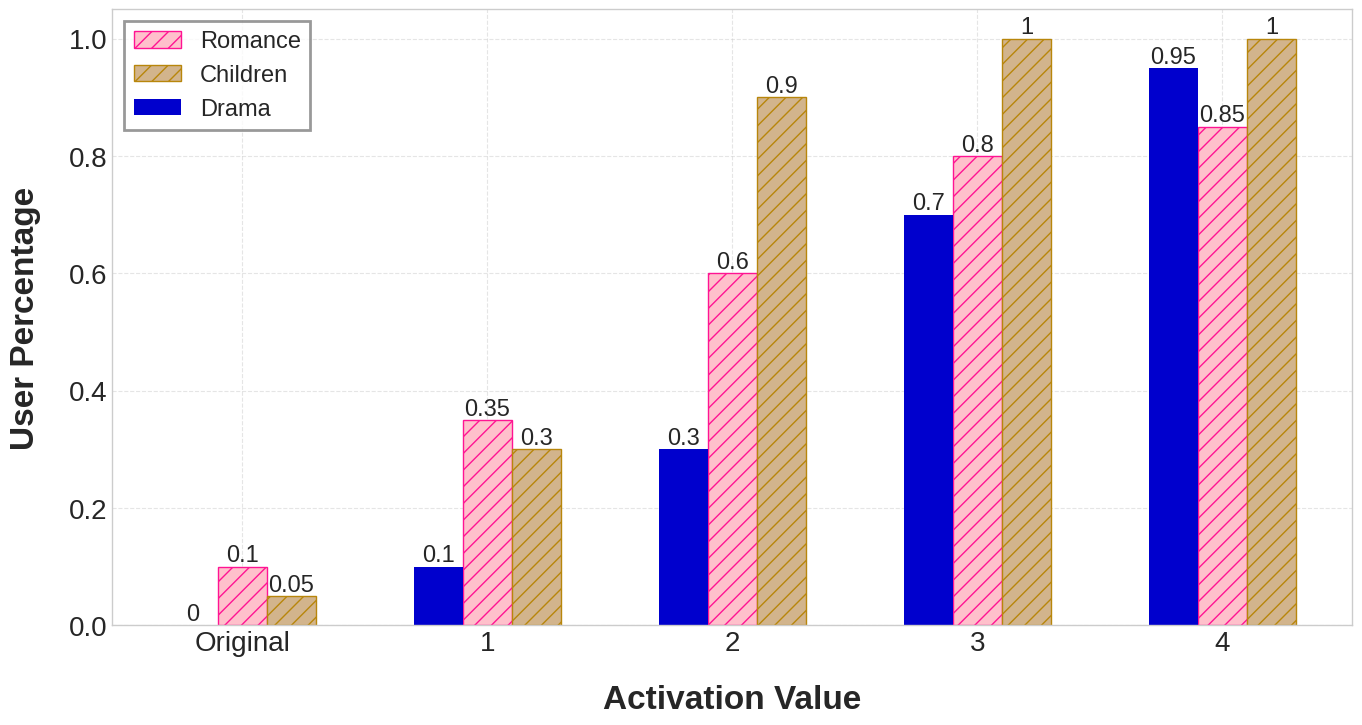

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 6))

concepts = ['Drama','Children' ,'Romance']


a = [round(ob/numUsersOuttopk_orig[0], 2) for ob in numUsersTotopk]
r = ax1.bar([0.2, 1.2, 2.2, 3.2, 4.2], a, color='pink', width=0.2, hatch = '//',edgecolor='deeppink')
ax1.bar_label(r, fontsize=14)

a = [round(ob/numUsersOuttopk_orig1[0], 2) for ob in numUsersTotopk1]
r = ax1.bar([0.4, 1.4, 2.4, 3.4, 4.4], a, color='tan', width=0.2, hatch = '//',edgecolor='darkgoldenrod')

a1 = [round(ob/numUsersOuttopk_orig2[0], 2) for ob in numUsersTotopk2[0:5]]
r1 = ax1.bar(neuron_levels, a1, color='mediumblue', width=0.2)
ax1.bar_label(r1, fontsize=14)

ax1.set_xlabel('Activations Values', labelpad=20, weight='bold', fontsize=20)
ax1.set_ylabel('User Percentage', labelpad=20, weight='bold', fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=17)

# Prepare custom x-axis labels
label_x = neuron_levels.copy()
label_x[0] = 'Original'

# Set the x-tick positions and labels only once:
ax1.set_xticks([0.2, 1.2, 2.2, 3.2, 4.2])
ax1.set_xticklabels(label_x, fontsize=17)
ax1.tick_params(axis='both', labelsize=17 )

leg = ax1.legend(['Romance', 'Children', 'Drama'],
                 loc='upper left', fontsize=14, fancybox=False, frameon=True)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)

plt.show()


# Latent user representation intervention

 ##  USE CASE 2: Nudging users toward new content

choose an audience

In [ ]:
youngers = df_usr.iloc[np.where(df_usr['age']<18 )[0],:]  #and df_usr['age'] in autoencoder.test_subset_users_ind
indices = np.where(youngers['usr_id'].isin(sae_model.test_subset_users_ind))[0]
youngers = youngers.iloc[indices, :]

In [ ]:
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

genre_id = 0  #  children's- id in all_genre list
user_group_young = pd.DataFrame(0, index=range(youngers.shape[0]), columns=['user', 'percentage'])
for ind, user in enumerate(youngers['usr_id']):
  user_group_young.iloc[ind,0] = user
  p = np.where(ratings_matrix.loc[user]==1)
  user_group_young.iloc[ind,1] = df_movie.iloc[p[0],0:-1].sum().iloc[genre_id]/df_movie.iloc[p[0],0:-1].sum().sum()


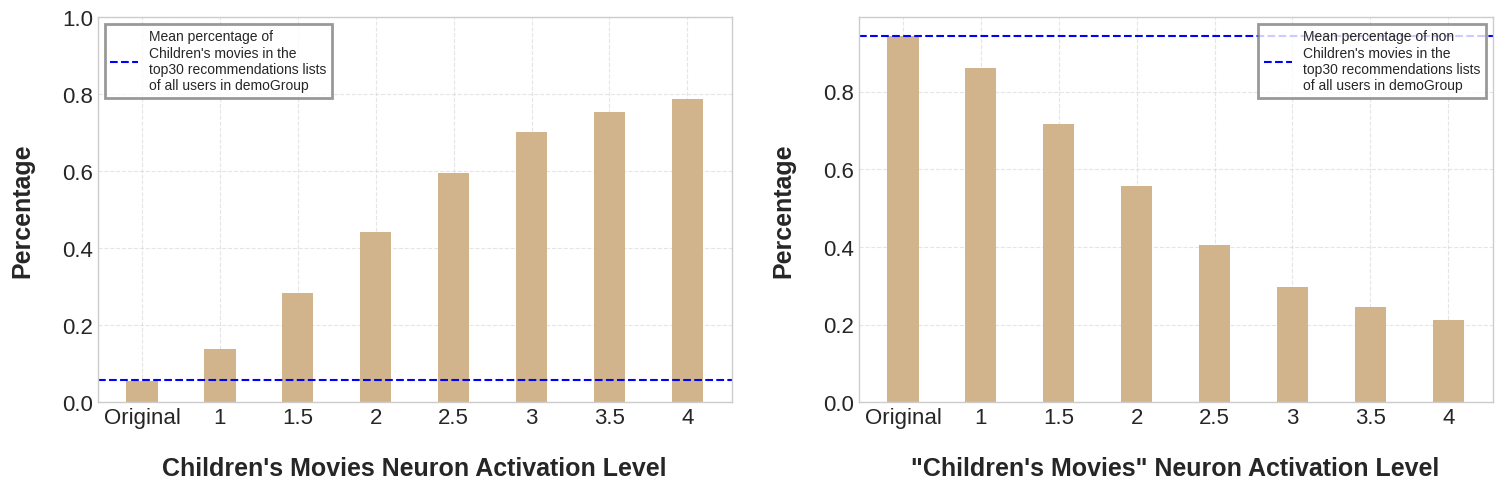

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0

target_concept = 'Children\'s'
target_neuron = 3


neuron_levels = [0.5, 1, 1.5, 2,2.5,3,3.5,4]

table = pd.DataFrame(0, index=range(len(user_group_young['user'])), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:
  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in user_group_young['user']:


    # for original recommendations:
    top_rec_user_orig = get_top_k_recommendations(model, user2, list(range(3706)), movie_num2)[1]


    a_orig = df_movie.iloc[top_rec_user_orig,:-1].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[target_concept])/movie_num2


    orig_genres_percentage_newGenre = a_orig.loc[target_concept]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)




    # modified users:
    user_act =  latents_df_usr.copy().loc[user2,:]
    user_act_new = user_act.copy(deep=True)
    if level != 0.5:
      user_act_new.iloc[target_neuron]=level

    recons_user = sae_model.decoder(torch.tensor(user_act_new))

    # generate recommendation list

    top_rec_user_id_new2 = get_top_k_recommendations_flex_user(model, user2,
                          list(range(3706)), movie_num2, recons_user.detach().clone())[1]

    a2 = df_movie.iloc[top_rec_user_id_new2,:-1].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[target_concept])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[target_concept]/movie_num2

    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)


  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


neuron_levels_block = neuron_levels.copy()
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Mean percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Children\'s Movies Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
leg = ax1.legend([f'Mean percentage of\nChildren\'s movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax2.set_title(f'Mean percentage of non Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax2.set_xlabel('"Children\'s Movies" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\nChildren\'s movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




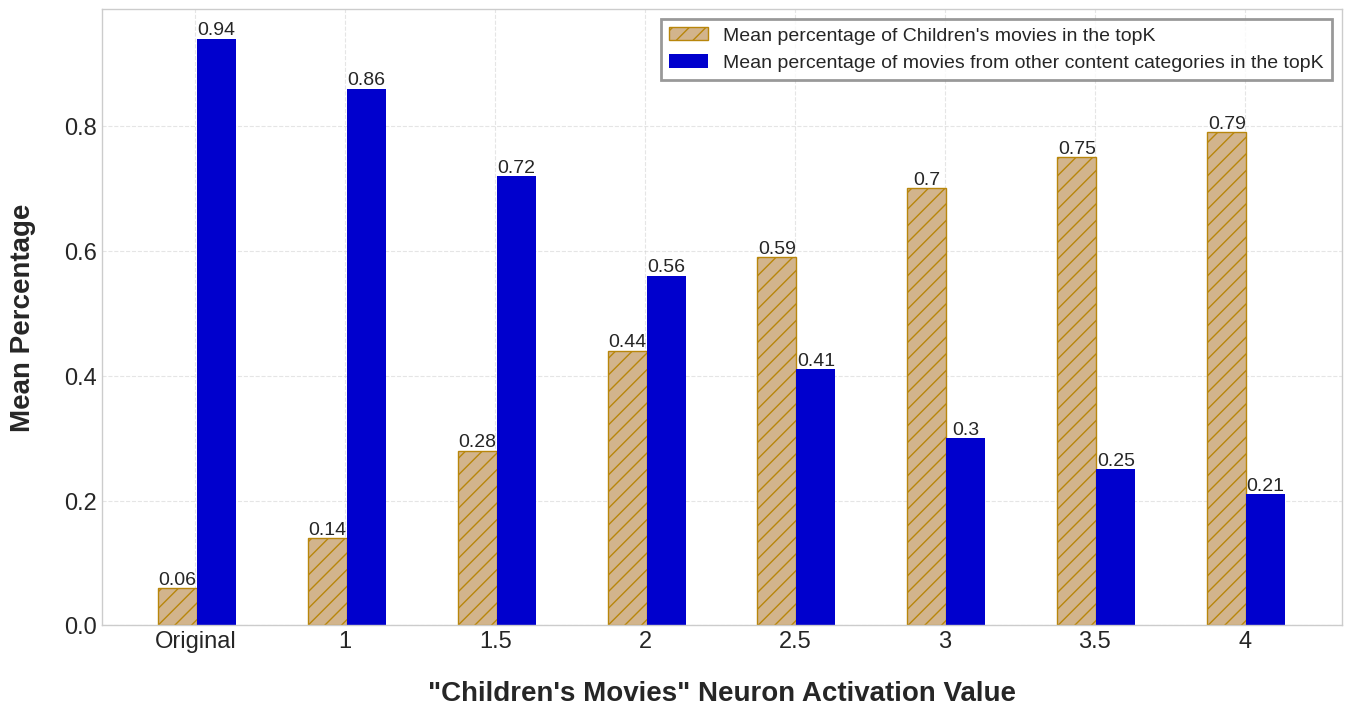

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.13, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([0.63, 1.13, 1.63, 2.13, 2.63, 3.13, 3.63, 4.13], b, color='mediumblue', width= 0.13)
ax1.bar_label(r2,fontsize=14)

# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
# ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Averaged percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('"Children\'s Movies" Neuron Activation Value', labelpad=20,weight='bold',fontsize=20)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06, 3.56, 4.06])
# ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticklabels(neuron_levels_block,fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
leg = plt.legend([f'Mean percentage of Children\'s movies in the topK', f'Mean percentage of movies from other content categories in the topK'],frameon=True, loc='upper right', fontsize=14, fancybox=False)
# Access the legend frame and set its edge color and linewidth
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

 ## USE CASE  3: Post hoc content suppression

In [ ]:
'''find the group'''
'''list of users that watched movies of certain genre, sorted by the number of
movies of the certain genre wrt the total number of movies ranked by the user'''
# all_genres = ['Children\'s','Drama', 'Action','Comedy', 'Adventure','Documentary',
#               'Animation', 'Crime','Fantasy','Film-Noir','Mystery', 'Horror',
#               'Musical', 'Romance','Sci-Fi', 'Thriller', 'War', 'Western']

demoUsersGroup = generate_users_test_group('Action', N, sae_model)
demoUsersGroup

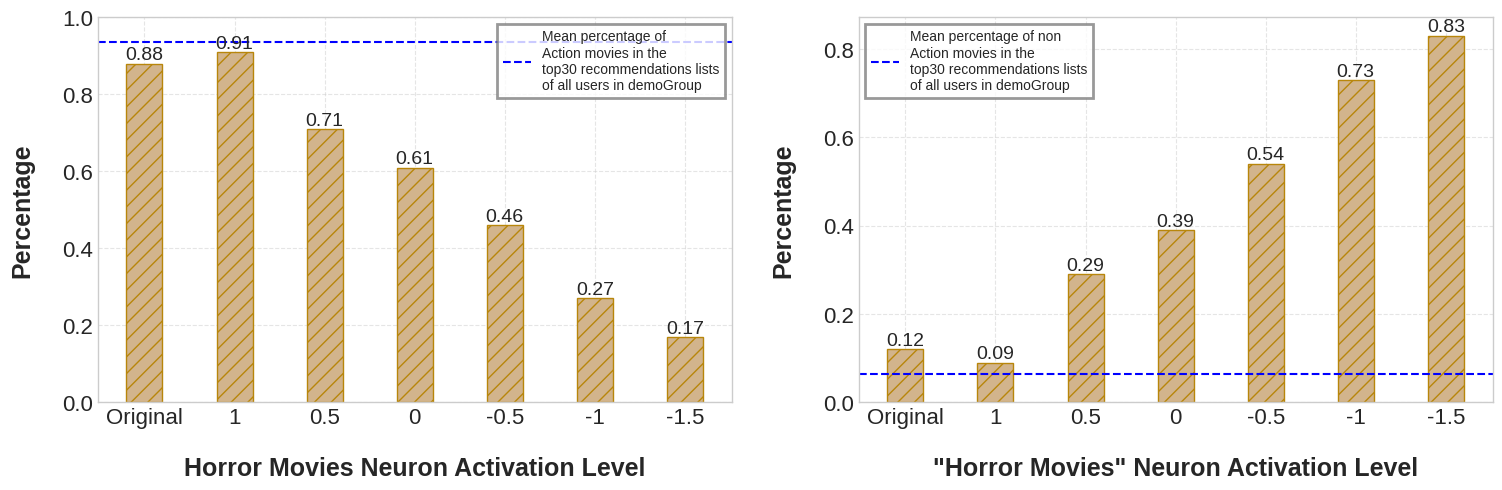

In [ ]:
movie_num2 = 30
meanTestGenreMoviesInTopK4DemoGroup_orig = []
meanTestGenreMoviesInTopK4DemoGroup = []
meanOldGenreMoviesInTopK4DemoGroup_orig = []
meanOldGenreMoviesInTopK4DemoGroup = []
genresOld_percentage_all_orig = []
genresNew_percentage_all_orig = []
genresOld_percentage_all = []
genresNew_percentage_all = []
no_effect_users = []
no_effect_users_count = 0

target_neuron = 12
target_concept = 'Action'


'''dealing here with orig/new results and old/new genres'''

neuron_levels = [-1.5,-1,-0.5,0,0.5,1, 1.5]


'''what place 'test_movie' has among all recommendations of all relevant users '''
table = pd.DataFrame(0, index=range(len(demoUsersGroup.index)), columns=['user', 'orig rec rank', 'new rec rank'])

for level in neuron_levels:

  no_effect_users_count=0

  genresOld_percentage_all_orig=[]
  genresOld_percentage_all=[]
  genresNew_percentage_all_orig=[]
  genresNew_percentage_all = []

  for user2 in demoUsersGroup.index:


    # for original recommendations:
    top_rec_user_orig = get_top_k_recommendations(model, user2, list(range(3706)), movie_num2)[1]
    # # real indices because of df_item_emb
    # top_rec_user_id_orig = top_rec_user_orig.index
    # print(top_rec_user_id_orig)

    a_orig = df_movie.iloc[top_rec_user_orig,:-1].sum()
    orig_genres_percentage_oldGenre = (movie_num2-a_orig.loc[target_concept])/movie_num2

    orig_genres_percentage_newGenre = a_orig.loc[target_concept]/movie_num2
    genresOld_percentage_all_orig.append(orig_genres_percentage_oldGenre)
    genresNew_percentage_all_orig.append(orig_genres_percentage_newGenre)



    # new/ current results: for old and new/test/curr genres:

    # modified users:
    user_act =  latents_df_usr.copy().loc[user2,:]
    user_act_new = user_act.copy(deep=True)

    if level != -1.5:
      user_act_new.iloc[target_neuron]=level*(-1)

    recons_user = sae_model.decoder(torch.tensor(user_act_new))

    top_rec_user_id_new2 = get_top_k_recommendations_flex_user(model, user2,
                          list(range(3706)), movie_num2, recons_user.detach().clone())[1]

    a2 = df_movie.iloc[top_rec_user_id_new2,:-1].sum()

    curr_genres_percentage_oldGenre = (movie_num2-a2.loc[target_concept])/movie_num2
    curr_genres_percentage_newGenre = a2.loc[target_concept]/movie_num2


    genresOld_percentage_all.append(curr_genres_percentage_oldGenre)
    genresNew_percentage_all.append(curr_genres_percentage_newGenre)


  # each item in the list represents the averaged percentage of movies of test_genre in the topK recommendations list of all users in demoGroup
  #  new/curr/test genre:
  #orig results for new genre:
  meanTestGenreMoviesInTopK4DemoGroup_orig.append(sum(genresNew_percentage_all_orig)/len(genresNew_percentage_all_orig))

  #new results for new gennres:
  meanTestGenreMoviesInTopK4DemoGroup.append(sum(genresNew_percentage_all)/len(genresNew_percentage_all))


  #  old genre:
  # orig results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup_orig.append(sum(genresOld_percentage_all_orig)/len(genresOld_percentage_all_orig))

  # new results for old genre:
  meanOldGenreMoviesInTopK4DemoGroup.append(sum(genresOld_percentage_all)/len(genresOld_percentage_all))

  # number of users we didnt influence to watch more test_genre movies
  no_effect_users.append(no_effect_users_count)


neuron_levels_names = neuron_levels.copy()
neuron_levels_names[0] = 'orig'


# IF WE'RE TALKING ABOUT BLOCKIING- ADD THIS REPLACE WITH neuron_levels_names
neuron_levels_block = neuron_levels.copy()
neuron_levels_block = [item* (-1) for item in neuron_levels_block]
neuron_levels_block[0] = 'Original'


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.2, hatch='//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)
# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Mean percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Horror Movies Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax1.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)
ax1.grid(True, linestyle='--', alpha=0.5)

ax1.set_xticks(neuron_levels)
ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=16)
ax1.set_xticklabels(neuron_levels_block,fontsize=16)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=16)# ax1.tick_params(axis='y', labelsize=14)
leg = ax1.legend([f'Mean percentage of\nAction movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper right', fontsize=10, fancybox=False)
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)



# old genre:
b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax2.bar(neuron_levels, b, color='tan', width= 0.2, hatch='//', edgecolor = 'darkgoldenrod')
ax2.bar_label(r2,fontsize=14)
# ax2.bar(neuron_levels, meanOldGenreMoviesInTopK4DemoGroup, color='tan', width= 0.2)
ax2.axhline(y=meanOldGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax2.set_title(f'Mean percentage of non Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax2.set_xlabel('"Horror Movies" Neuron Activation Level', labelpad=20,weight='bold',fontsize=18)
ax2.set_ylabel('Percentage', labelpad=20,weight='bold',fontsize=18)

ax2.grid(True, linestyle='--', alpha=0.5)
ax2.tick_params(axis='both', labelsize=16)
ax2.set_xticks(neuron_levels)
ax2.set_xticklabels(neuron_levels_block,fontsize=16)
leg = ax2.legend([f'Mean percentage of non\nAction movies in the\ntop{movie_num2} recommendations lists\nof all users in demoGroup'],frameon=True, loc='upper left', fontsize=10, fancybox=False)
# Access the legend frame and set its edge color and
frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)




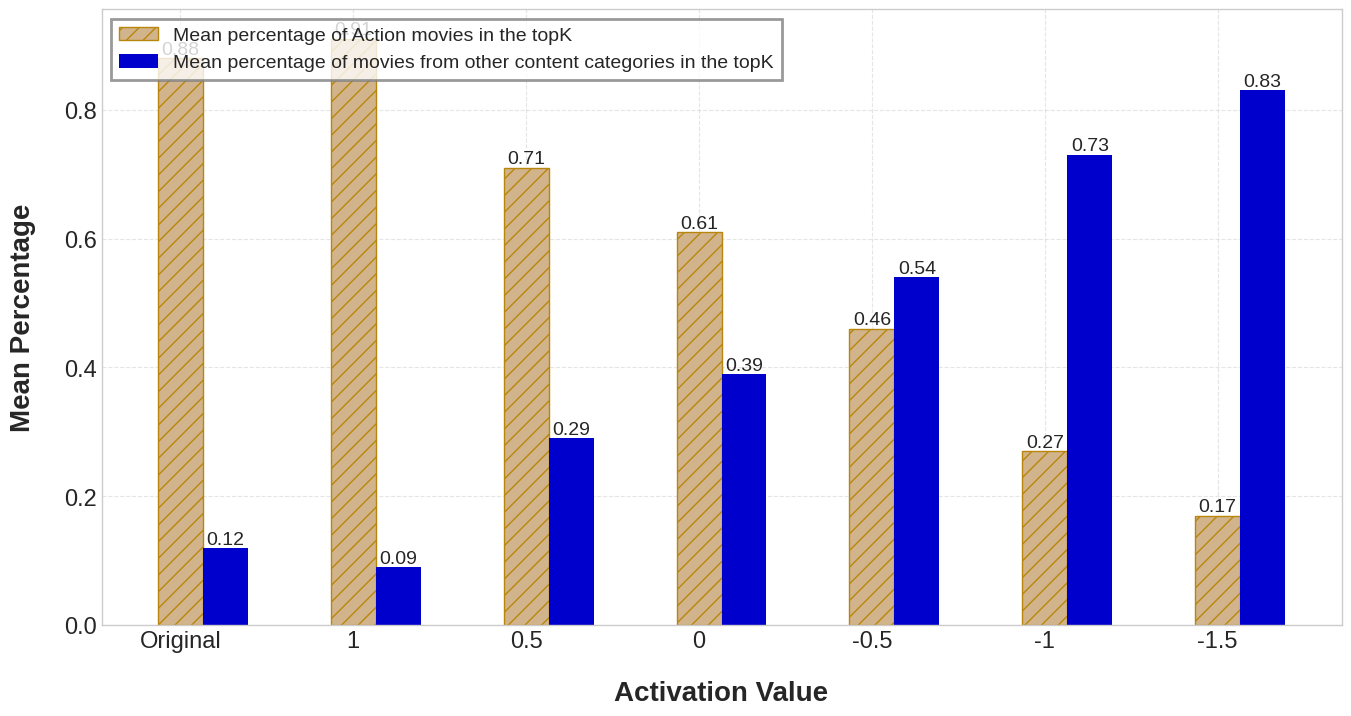

In [ ]:
fig, (ax1) = plt.subplots(1,1, figsize=(16, 8))


# new/curr/test genre:
a = [round(ob,2) for ob in meanTestGenreMoviesInTopK4DemoGroup]
r1=ax1.bar(neuron_levels, a, color='tan', width= 0.13, hatch = '//', edgecolor = 'darkgoldenrod')
ax1.bar_label(r1,fontsize=14)

b = [round(ob,2) for ob in meanOldGenreMoviesInTopK4DemoGroup]
r2=ax1.bar([-1.37,-0.87,-0.37,0.13,0.63, 1.13, 1.63], b, color='mediumblue', width= 0.13)
ax1.bar_label(r2,fontsize=14)

# ax1.bar(neuron_levels, meanTestGenreMoviesInTopK4DemoGroup, color='tan', width= 0.3)
# ax1.axhline(y=meanTestGenreMoviesInTopK4DemoGroup_orig[0], color='blue', linestyle='--')
# ax1.set_title(f'Averaged percentage of Children\'s movies in the top{movie_num2} \nrec list of all users in demoGroup',fontsize=17)
ax1.set_xlabel('Activation Value', labelpad=20,weight='bold',fontsize=20)
ax1.set_ylabel('Mean Percentage', labelpad=20,weight='bold',fontsize=20)
ax1.grid(True, linestyle='--', alpha=0.5)

# ax1.set_xticks([0.56, 1.06, 1.56, 2.06, 2.56, 3.06, 3.56, 4.06])
# ax1.set_yticks([0.0, 0.2, 0.4,0.6,0.8,1.0])

ax1.tick_params(axis='both', labelsize=17)
ax1.set_xticks(neuron_levels)
ax1.set_xticklabels(neuron_levels_block,fontsize=17)
ax1.set_yticklabels([0.0, 0.2, 0.4,0.6,0.8,1.0],fontsize=17)# ax1.tick_params(axis='y', labelsize=14)
# leg = plt.legend([f'Mean percentage of Horror movies in the top{movie_num2}', f'Mean percentage of movies from other content categories in the top{movie_num2}'],frameon=True, loc='upper left', fontsize=14, fancybox=False)
leg = plt.legend([f'Mean percentage of Action movies in the topK', f'Mean percentage of movies from other content categories in the topK'],frameon=True, loc='upper left', fontsize=14, fancybox=False)

frame = leg.get_frame()
frame.set_edgecolor('grey')
frame.set_linewidth(2)






-

# NCF & MF SAE loss term

test the rank correlation scores using RBO & Kentall Tau wrt prediction level loss term

In [ ]:
test_flag=1
val_output_loss_weight = 0


model_name_SAE_NCF = 'SAE_NCF_loss_weight2'

sae_model = SparseAutoencoderNCF(input_dim=20, hidden_dim=22, topk=7, tie_weights=True)
sae_model = torch.load(Path(export_dir,f'models/others/{model_name_SAE_NCF}.pth'), weights_only = False)
sae_model.eval()
test_subset_users = sae_model.test_subset_users_ind
test_subset_items = sae_model.test_subset_items_ind
train_subset_users = [i for i in ratings_matrix.index if i not in test_subset_users]


users_ind= ratings_matrix.index[sae_model.test_subset_users_ind]
lists_compare_table = pd.DataFrame(0, index=users_ind, columns=['RBO Score', 'Kendall Tau Score'])
for user in lists_compare_table.index:

  _,a,rec_orig = get_top_k_recommendations(model, user, list(range(3706)), 30)
  top_rec_user_id_orig = [int(t[0]) for t in rec_orig]
  _,b,rec_reconst = get_top_k_recommendations_flex(model, user, list(range(3706)), 30)
  top_rec_user_id_rec = [int(t[0]) for t in rec_reconst]


  lists_compare_table.loc[user,'RBO Score'] = rbo(a, b)
  lists_compare_table.loc[user,'Kendall Tau Score'] = kendall_tau(a, b)

print(f'{round(float(lists_compare_table.mean().iloc[0]),6)} | {round(float(lists_compare_table.mean().iloc[1]),6)}')

In [ ]:
#movielens- draft

import matplotlib.pyplot as plt

# Use a Seaborn style (or any style you prefer)
plt.style.use('seaborn-v0_8-whitegrid')

# Create a figure with two subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))

# --- Graph 1 ---
ax1.plot([0, 1, 2, 5, 10], [0.09, 0.24, 0.32, 0.448, 0.597], color='mediumblue', ls='-.', marker='o',markersize = 8)
ax1.plot([0, 1, 2, 5, 10],[-0.19, 0.092,0.141, 0.226, 0.315], color='crimson', ls='-.', marker='X', markersize = 10)
ax1.set_xlabel('β', labelpad=15, weight='bold', fontsize=20)
ax1.set_ylabel('Kendall Tau Correlation Score', labelpad=15, weight='bold', fontsize=20)
# ax1.set_yticks([-0.2, 0, 0.2,0.4, 0.6, 0.8,1.0])
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
leg1 = ax1.legend(['NCF Model', 'MF Model'], frameon=True, loc='best', fontsize=14, fancybox=False)
leg1.get_frame().set_edgecolor('grey')
leg1.get_frame().set_linewidth(2)

# --- Graph 2 ---
# (Replace the data below with your desired plot data for the second graph.)
ax2.plot([0, 1, 2, 5, 10], [0.448, 0.55, 0.579,0.664, 0.748], color='mediumblue', ls='-.', marker='o',markersize = 8)
ax2.plot([0, 1, 2, 5, 10], [0.224, 0.403, 0.436, 0.4859, 0.543], color='crimson', ls='-.', marker='X', markersize = 10)
# ax2.set_yticks([-0.2, 0, 0.2,0.4, 0.6, 0.8,1.0])
ax2.set_xlabel('β', labelpad=15, weight='bold', fontsize=20)
ax2.set_ylabel('RBO Correlation Score', labelpad=15, weight='bold', fontsize=20)
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
leg2 = ax2.legend(['NCF Model', 'MF Model'], frameon=True, loc='best', fontsize=14, fancybox=False)
leg2.get_frame().set_edgecolor('grey')
leg2.get_frame().set_linewidth(2)

fig.subplots_adjust(wspace=0.4)


# --- Graph 2 ---
# (Replace the data below with your desired plot data for the second graph.)
ax3.plot([0, 1, 2, 5, 10], [0.658, 0.671, 0.681,0.676133, 0.6735], color='mediumblue', ls='-.', marker='o',markersize = 8)
ax3.plot([0, 1, 2, 5, 10], [0.464 ,0.58, 0.578, 0.567, 0.553], color='crimson', ls='-.', marker='X', markersize = 10)
ax3.set_xticks([0.0, 2.0,4.0, 6.0, 8.0,10.0])
ax3.set_xlabel('β', labelpad=15, weight='bold', fontsize=20)
ax3.set_ylabel('Monosemanticity Score', labelpad=15, weight='bold', fontsize=20)
ax3.tick_params(axis='x', labelsize=16)
ax3.tick_params(axis='y', labelsize=16)
leg3 = ax3.legend(['NCF Model', 'MF Model'], frameon=True, loc='best', fontsize=14, fancybox=False)
leg3.get_frame().set_edgecolor('grey')
leg3.get_frame().set_linewidth(2)

fig.subplots_adjust(wspace=0.4)
# plt.tight_layout()
plt.show()
